### Полносвязные нейронные сети.

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random

In [ ]:
# %conda install wget

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [2]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [3]:
df.isnull().sum().sum() # пропуски в датасете отсутствуют

0

In [4]:
df.shape

(515345, 91)

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [6]:
X_train.shape

(463715, 90)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучим `Ridge` регрессию из `sklearn`. Кроме того, посчитаем качество при наилучшем константном прогнозе.

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [8]:
ridge = Ridge(10)
ridge.fit(X_train,y_train)
print ("Train: {}".format(np.sqrt(mean_squared_error(y_train, ridge.predict(X_train)))))
print ("Test: {}".format(np.sqrt(mean_squared_error(y_test, ridge.predict(X_test)))))

Train: 9.552822967905987
Test: 9.510160746337895


Выясним какое С оптимально (для констатного предсказания). У нас есть выборка $(X_1,...,X_n)$ - наши значени игрека из y_train. Тогда функция потерь выглядит так: $f(C) = \frac{1}{n}\sum\limits_{i=1}^n{(X_i - C) ^ 2}$. Нам надо эту функцию минимизировать по С. Берем производную: $f'(C) = -\frac{2}{n}\sum\limits_{i=1}^n{(X_i - C)}$. Это равняется нулю если и только если $\sum\limits_{i=1}^n{(X_i - C)} = 0 \Rightarrow C = \frac{1}{n}\sum\limits_{i=1}^n{X_i}$ , то есть С просто равно среднему.

In [9]:
C = y_train.mean()
print ("Train: {}".format(np.sqrt(mean_squared_error(y_train, C * np.ones(len(y_train))))))
print ("Test: {}".format(np.sqrt(mean_squared_error(y_test, C * np.ones(len(y_test))))))

Train: 10.939755150678016
Test: 10.85246390513634


Реализуем обучение и тестирование нейронной сети для предоставленного вам набора данных. Основная задача - побить рубеж в 8.75

In [8]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
# Отнормируем данные и таргет. Данные с помощью MinMaxScaler, а таргет вручную с запоминанием некоторых значений, чтобы потом
# можно было восстановить нормальные значения ошибки (а то RMSE будет < 1)

In [12]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

delta = max(y_train) - min(y_train) # Запоминаем, чтобы потом вернуть таргету прежнии значения
Min = min(y_train) # Запоминаем, чтобы потом вернуть таргету прежнии значения
y_train = (y_train - Min) / delta # Нормируем таргет
y_test = (y_test - Min) / delta

In [14]:
delta, Min

(89, 1922)

In [13]:
y_train # Посмотрим что получили после нормировки

array([0.88764045, 0.88764045, 0.88764045, ..., 0.95505618, 0.94382022,
       0.95505618])

In [ ]:
# Для того, чтобы можно было работать со всеми этими лоадерами и т.д., нужен вспомогательный класс:

In [7]:
class MyDataset(torch.utils.data.Dataset):
    """
    Обернем наш датасет в такой класс для удобства
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return [torch.tensor(self.x[idx, :], dtype=torch.double), self.y[idx]]

In [ ]:
# Собственно основные моменты (лоадеры, модель, оптимизатор, лосс):

In [17]:
set_random_seed(123)
train_set = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16) # сделаем не слишком большой/маленький батч

test_set = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16)

model = nn.Sequential(           
    nn.Linear(90, 128),  # первый слой 90 -> 128 (у объекта же 90 признаков)
    nn.BatchNorm1d(128), # Batch нормализация после каждого слоя
    nn.ReLU(),           # нелинейность   
    nn.Dropout(0.2),     # регуляризация в виде выбрасывания 20% нейронов (после нелинейности!)
    nn.Linear(128, 128), # второй слой
    nn.BatchNorm1d(128),
    nn.ReLU(),        
    nn.Dropout(0.2),
    nn.Linear(128, 1)   # 1 выход - число, так как мы решаем задачу регрессии
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # стохастический градиентный спуск с размером шага 0.01
criterion = torch.nn.MSELoss() # просто достаем из библиотеки MSE. Будем ее оптимизировать, а для вывода результатов не забудем
                               # извлечь корень

In [130]:
def train(model, optimizer, criterion, train_loader, test_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    set_random_seed(123)
    test_overall = [] # лосс на тесте на каждой эпохе (то есть тут будет epochs значений)
    train_overall = [] # лосс на трейне на каждой эпохе
    for epoch in range(30): # Ну путь будет столько эпох
        model.train()
        train_RMSE = [] # тут будут лоссы по батчам трейна (обновляется каждую эпоху)
        for batch in train_loader:
            x_train = batch[0]                              # Извлекаем данные и таргет из MyDataset (у нас же на нулевом месте
            y_train = batch[1]                              # в списке данные, а на первом - таргет)
            y_pred = model(x_train.float()).squeeze()         # Делаем предсказания
            loss = criterion(y_pred, y_train.float())        # Считаем лосс
            loss.backward()                                # Считаем градиенты
            optimizer.step()                               # Делаем шаг градиентного спуска
            optimizer.zero_grad()                          # Обнуляем градиенты
            with torch.no_grad():
                l = torch.mean((y_pred * delta + Min - (y_train.float() * delta + Min)) ** 2) # Вот тут мы считаем лосс, приводя
                # таргет обратно к нормально виду (мы там в начале запоминали Min и delta)
                train_RMSE.append(np.sqrt(l.numpy()))
                
        train_overall.append(np.mean(train_RMSE)) # аппендим средний лосс по всем батчам на этой эпохе
        
        # Сразу же будем отслеживать лосс на тесте
        test_RMSE = [] # тут будут лоссы по батчам треста (обновляется каждую эпоху)
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                x_test = batch[0]
                y_test = batch[1]
                y_pred = model(x_test.float()).squeeze()
                loss = criterion((y_pred * delta + Min), (y_test * delta + Min).float()) # Вот тут мы считаем лосс, приводя
                # таргет обратно к нормально виду (мы там в начале запоминали Min и delta)
                test_RMSE.append(np.sqrt(loss.numpy()))
        # печатаем метрики
        print(f"Epoch: {epoch}, test_RMSE: {np.mean(test_RMSE)}")
        test_overall.append(np.mean(test_RMSE)) # аппендим средний лосс по всем батчам на этой эпохе
    return train_overall, test_overall # будем возвращать лоссы на тесте и трейне по эпохам, чтобы потом визуализировать 

In [26]:
set_random_seed(123)
train_overall, test_overall = train(model, optimizer, criterion, train_loader, test_loader)

Epoch: 0, test_RMSE: 8.972068786621094
Epoch: 1, test_RMSE: 9.019654273986816
Epoch: 2, test_RMSE: 9.003498077392578
Epoch: 3, test_RMSE: 9.014179229736328
Epoch: 4, test_RMSE: 8.97346019744873
Epoch: 5, test_RMSE: 8.954983711242676
Epoch: 6, test_RMSE: 8.96605396270752
Epoch: 7, test_RMSE: 9.00307559967041
Epoch: 8, test_RMSE: 9.028141021728516
Epoch: 9, test_RMSE: 8.992053031921387
Epoch: 10, test_RMSE: 8.96348762512207
Epoch: 11, test_RMSE: 8.8606595993042
Epoch: 12, test_RMSE: 8.880810737609863
Epoch: 13, test_RMSE: 8.92302131652832
Epoch: 14, test_RMSE: 8.908039093017578
Epoch: 15, test_RMSE: 8.941986083984375
Epoch: 16, test_RMSE: 8.979124069213867
Epoch: 17, test_RMSE: 8.91344928741455
Epoch: 18, test_RMSE: 8.929966926574707
Epoch: 19, test_RMSE: 8.915164947509766
Epoch: 20, test_RMSE: 8.96342945098877
Epoch: 21, test_RMSE: 8.954499244689941
Epoch: 22, test_RMSE: 8.876206398010254
Epoch: 23, test_RMSE: 8.941410064697266
Epoch: 24, test_RMSE: 8.914216041564941
Epoch: 25, test_RMS

In [33]:
train_overall = np.array(train_overall)
train_overall

array([8.746986 , 8.752957 , 8.760728 , 8.768742 , 8.773994 , 8.782473 ,
       8.790163 , 8.795961 , 8.804413 , 8.809401 , 8.815835 , 8.8212385,
       8.827121 , 8.83288  , 8.839364 , 8.844675 , 8.846638 , 8.852805 ,
       8.855947 , 8.860588 , 8.861673 , 8.868319 , 8.868179 , 8.874906 ,
       8.87506  , 8.876888 , 8.877655 , 8.880895 , 8.8829   , 8.883113 ],
      dtype=float32)

In [34]:
test_overall = np.array(test_overall)
test_overall

array([8.972069, 9.019654, 9.003498, 9.014179, 8.97346 , 8.954984,
       8.966054, 9.003076, 9.028141, 8.992053, 8.963488, 8.86066 ,
       8.880811, 8.923021, 8.908039, 8.941986, 8.979124, 8.913449,
       8.929967, 8.915165, 8.963429, 8.954499, 8.876206, 8.94141 ,
       8.914216, 8.944127, 8.927295, 8.929907, 8.95055 , 8.9031  ],
      dtype=float32)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# визуализируем (ошибка в зависимости от номера эпохи)

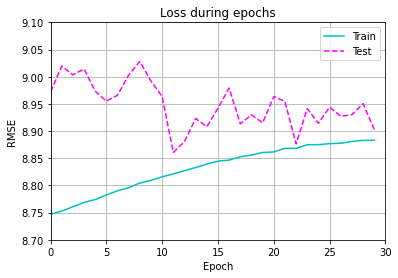

In [40]:
x = np.arange(0, 30)

plt.plot(x, train_overall, 'c', linestyle = '-')
plt.plot(x, test_overall, 'magenta', linestyle = '--')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Loss during epochs")
plt.legend(['Train', 'Test'])
plt.grid()
plt.axis([0, 30, -1.2, 1.2])
plt.ylim(8.7, 9.1)
plt.show()

In [ ]:
# ну вроде и опускается ниже 8.9, но хочется лучше. Продолжим поиски хорошей модели

In [84]:
y_pred = torch.Tensor([])
for x, y in tqdm(test_loader):
    y_batch = model(x.float())
    y_pred = torch.cat((y_pred, y_batch), 0)
y_pred = y_pred.detach().numpy() * delta + Min
mean_squared_error(y_pred, y_test * delta + Min)**(1/2)

  0%|          | 0/3227 [00:00<?, ?it/s]

10.689758637565511

In [ ]:
# bad...

In [56]:
# тут я поменял размеры некоторых слоев, а также убрал BatchNorm и один Dropout
# сработало, однако
set_random_seed(123)
model1 = nn.Sequential(           
    nn.Linear(90, 64),  # первый слой 90 -> 64 (у объекта же 90 признаков)
    #nn.BatchNorm1d(64), # Batch нормализация после каждого слоя
    nn.ReLU(),           # нелинейность   
    nn.Dropout(0.2),     # регуляризация в виде выбрасывания 20% нейронов (после нелинейности!)
    nn.Linear(64, 128), # второй слой
    #nn.BatchNorm1d(128),
    nn.ReLU(),        
    #nn.Dropout(0.3),
    nn.Linear(128, 1)   # 1 выход - число, так как мы решаем задачу регрессии
)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01) # стохастический градиентный спуск с размером шага 0.01
criterion1 = torch.nn.MSELoss() # просто достаем из библиотеки MSE. Будем ее оптимизировать, а для вывода результатов не забудем
                               # извлечь корень

In [57]:
set_random_seed(123)
train_overall1, test_overall1 = train(model1, optimizer1, criterion1, train_loader, test_loader)

Epoch: 0, test_RMSE: 8.751925468444824
Epoch: 1, test_RMSE: 8.288558959960938
Epoch: 2, test_RMSE: 8.187527656555176
Epoch: 3, test_RMSE: 8.123811721801758
Epoch: 4, test_RMSE: 8.134510040283203
Epoch: 5, test_RMSE: 8.083037376403809
Epoch: 6, test_RMSE: 8.04208755493164
Epoch: 7, test_RMSE: 8.036205291748047
Epoch: 8, test_RMSE: 7.950870513916016
Epoch: 9, test_RMSE: 7.953354835510254
Epoch: 10, test_RMSE: 7.938246250152588
Epoch: 11, test_RMSE: 7.873656272888184
Epoch: 12, test_RMSE: 7.908360958099365
Epoch: 13, test_RMSE: 7.868372440338135
Epoch: 14, test_RMSE: 7.881365776062012
Epoch: 15, test_RMSE: 7.898017883300781
Epoch: 16, test_RMSE: 7.824026107788086
Epoch: 17, test_RMSE: 7.841625690460205
Epoch: 18, test_RMSE: 7.809647083282471
Epoch: 19, test_RMSE: 7.766821384429932
Epoch: 20, test_RMSE: 7.7766242027282715
Epoch: 21, test_RMSE: 7.879766941070557
Epoch: 22, test_RMSE: 7.82597017288208
Epoch: 23, test_RMSE: 7.8159661293029785
Epoch: 24, test_RMSE: 7.824450969696045
Epoch: 25,

In [58]:
train_overall2 = np.array(train_overall1)
test_overall2 = np.array(test_overall1)

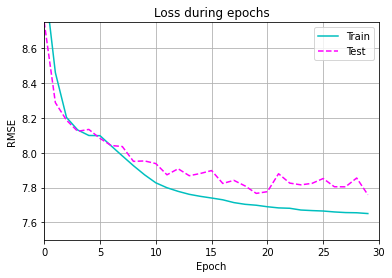

In [60]:
x = np.arange(0, 30)

plt.plot(x, train_overall2, 'c', linestyle = '-')
plt.plot(x, test_overall2, 'magenta', linestyle = '--')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Loss during epochs")
plt.legend(['Train', 'Test'])
plt.grid()
plt.axis([0, 30, -1.2, 1.2])
plt.ylim(7.5, 8.75)
plt.show()

In [76]:
from tqdm.notebook import tqdm

In [78]:
y_pred = torch.Tensor([])
for x, y in tqdm(test_loader):
    y_batch = model1(x.float())
    y_pred = torch.cat((y_pred, y_batch), 0)
y_pred = y_pred.detach().numpy() * delta + Min

  0%|          | 0/3227 [00:00<?, ?it/s]

In [80]:
mean_squared_error(y_pred, y_test * delta + Min)**(0.5)

9.332050176457345

In [ ]:
# вышло лучше, но все равно недостаточно

In [ ]:
# сделаем по-другому (используем теперь стандарт скейлер, увеличим размер батча и увеличим количество слоев)

In [9]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [10]:
from sklearn.preprocessing import StandardScaler

x_scale = StandardScaler()
y_scale = StandardScaler()
X_train = x_scale.fit_transform(X_train)
y_train = y_scale.fit_transform(y_train.reshape(-1, 1))
X_test = x_scale.transform(X_test)
y_test = y_scale.transform(y_test.reshape(-1, 1))

In [32]:
train_set = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, 64, shuffle=True)

test_set = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, 64)

model0 = nn.Sequential(
    nn.Linear(90, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(200, 250),
    nn.BatchNorm1d(250),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(250, 150),
    nn.BatchNorm1d(150),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(150, 1)
)
optimizer0 = torch.optim.Adam(model0.parameters(), lr = 0.00005) # уменьшил размер шага
criterion0 = nn.MSELoss()

In [ ]:
# нужна новая тренирующая функция, так как теперь мы другим способом приводим таргет к изначальному виду
# еще немного поменял места, где извлекаю корень из MSE

In [13]:
def train123(model, optimizer, criterion, train_loader, test_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    set_random_seed(123)
    test_overall = [] # лосс на тесте на каждой эпохе (то есть тут будет epochs значений)
    train_overall = [] # лосс на трейне на каждой эпохе
    for epoch in range(30): # Ну путь будет столько эпох
        model.train()
        train_RMSE = [] # тут будут лоссы по батчам трейна (обновляется каждую эпоху)
        for batch in train_loader:
            x_train = batch[0]                              # Извлекаем данные и таргет из MyDataset (у нас же на нулевом месте
            y_train = batch[1]                              # в списке данные, а на первом - таргет)
            y_pred = model(x_train.float())         # Делаем предсказания
            loss = criterion(y_pred, y_train.float())        # Считаем лосс
            loss.backward()                                # Считаем градиенты
            optimizer.step()                               # Делаем шаг градиентного спуска
            optimizer.zero_grad()                          # Обнуляем градиенты
            with torch.no_grad():
                l = torch.mean((y_pred * y_scale.scale_ - (y_train.float() * y_scale.scale_)) ** 2) # Вот тут мы считаем лосс, приводя
                # таргет обратно к нормально виду (тут поменялось по сравнению с функцией выше)
                train_RMSE.append(np.sqrt(l.numpy()))
                
        train_overall.append(np.mean(train_RMSE)) # аппендим средний лосс по всем батчам на этой эпохе
        
        # Сразу же будем отслеживать лосс на тесте
        test_RMSE = [] # тут будут лоссы по батчам треста (обновляется каждую эпоху)
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                x_test = batch[0]
                y_test = batch[1]
                y_pred = model(x_test.float())
                loss = criterion((y_pred * y_scale.scale_), (y_test * y_scale.scale_).float()) # Вот тут мы считаем лосс, приводя
                # таргет обратно к нормально виду (тут поменялось по сравнению с функцией выше)
                test_RMSE.append(np.sqrt(loss.numpy()))
        # печатаем метрики
        print(f"Epoch: {epoch}, test_RMSE: {np.mean(test_RMSE)}")
        test_overall.append(np.mean(test_RMSE)) # аппендим средний лосс по всем батчам на этой эпохе
    return train_overall, test_overall # будем возвращать лоссы на тесте и трейне по эпохам, чтобы потом визуализировать 

In [20]:
set_random_seed(123)
train_overall12, test_overall12 = train123(model0, optimizer0, criterion0, train_loader, test_loader)

Epoch: 0, test_RMSE: 7.863090602043939
Epoch: 1, test_RMSE: 7.809119712090244
Epoch: 2, test_RMSE: 7.821612255413812
Epoch: 3, test_RMSE: 7.922799275764027
Epoch: 4, test_RMSE: 7.851983705624058
Epoch: 5, test_RMSE: 7.78344609515816
Epoch: 6, test_RMSE: 7.874321012195974
Epoch: 7, test_RMSE: 7.849511071006962
Epoch: 8, test_RMSE: 7.750849842540982
Epoch: 9, test_RMSE: 7.9448513521751645
Epoch: 10, test_RMSE: 7.940471947646018
Epoch: 11, test_RMSE: 7.817727589640588
Epoch: 12, test_RMSE: 7.838796605352395
Epoch: 13, test_RMSE: 7.8470966144351095
Epoch: 14, test_RMSE: 7.832544913463845
Epoch: 15, test_RMSE: 7.852040091134357
Epoch: 16, test_RMSE: 7.874001267475516
Epoch: 17, test_RMSE: 7.765291181462832
Epoch: 18, test_RMSE: 7.825787151432791
Epoch: 19, test_RMSE: 7.909042501983797
Epoch: 20, test_RMSE: 7.865165895704271
Epoch: 21, test_RMSE: 7.89840833734061
Epoch: 22, test_RMSE: 7.85043582766901
Epoch: 23, test_RMSE: 7.839128551587283
Epoch: 24, test_RMSE: 7.921312088006433
Epoch: 25, 

In [21]:
train_overall12 = np.array(train_overall12)
test_overall12 = np.array(test_overall12)

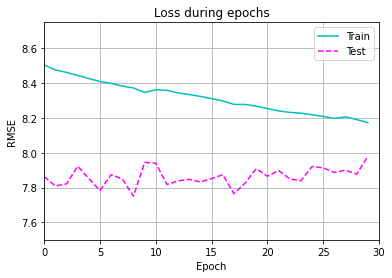

In [22]:
x = np.arange(0, 30)
plt.plot(x, train_overall12, 'c', linestyle = '-')
plt.plot(x, test_overall12, 'magenta', linestyle = '--')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Loss during epochs")
plt.legend(['Train', 'Test'])
plt.grid()
plt.axis([0, 30, -1.2, 1.2])
plt.ylim(7.5, 8.75)
plt.show()

In [40]:
set_random_seed(123)
y_pred = torch.Tensor([])
for x, y in tqdm(test_loader):
    y_batch = model0(x.float())
    y_pred = torch.cat((y_pred, y_batch), 0)
y_pred = y_scale.inverse_transform(y_pred.detach().numpy())
mean_squared_error(y_pred, y_scale.inverse_transform(y_test))**(1/2)

  0%|          | 0/807 [00:00<?, ?it/s]

8.741595869922078

In [ ]:
# ура!

Итого:

Пробовал по-разному делать. Сначала не нормировал датасет с таргетом, так как думал, что тогда RMSE будет маленьким и мы не сможем сравнить результат с бейзлайном. В этом случае возникала проблема, что лосс неограниченно рос, а затем вообще все улетало в nan. Справиться с этой проблем как раз помогла нормализация признаков. Я понял, что можно таргет нормализовать, пото обучить, а потом вернуть обратно, чтобы посчитать RMSE и получилось нормальное значение, которое можно сравнивать с бейзлайном.

Стал обучать модель в начале без Dropout, то есть была обычная полносвязная модель. Она давала не очень хорошие результаты, видимо, все-таки было переобучение. Потом обнаружил, что выставил слишком маленький шаг у оптимайзера: сходились невероятно долго. Выставил шаг 0.01 (с ним вроде более менее). В начале у меня еще был размер батча в 4 раза больше, но потом увидел в группе, что ассистенты обсуждали, что это много. Снизил до 16.

Моделей обучил довольно много: двухслойную (model = nn.Sequential(nn.Linear(90, 128), nn.ReLU(), nn.Linear(128, 1))) - ошибка было сильно больше 9, 

трехслойную (model = nn.Sequential(nn.Linear(90, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)) - та же проблема, ошибка около 9 - 9.3, 

потом добавил сразу и Dropout, и BatchNorm. Получил модель, которая есть выше (первая). На графике можно посмотреть на RMSE.

Дальше уже поигрался с weight_decay, который мне ничего не улучшал, попробовал поизменять размеры слоев и процент нейронов в dropout (все еще лосс гулял между 8.9 и 9.3). Повыкидывал из модели некоторые BatchNorm и Dropout. Результаты есть выше, но они не сильно хорошие вышли. Лучшая модель - последняя